# Train Feed-Forward network on pairwise distance between facial landmarks

In [1]:
# Modules
from utils import *
from data_preprocess import *
from models import *

# Tensorflow / Keras / sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# Utils
from ipywidgets import IntProgress
from matplotlib.ticker import MaxNLocator

## Load dataset

In [2]:
# Load annotations
annotations = load_annotations('./data/annotations.csv')
# Convert labels to categorical
annotations['class'] = labels_to_categorical(annotations[['smile', 'mouth_open']])
labels = annotations['class'].values

In [3]:
# Calculate pairwise distance between facial landmarks
# distances = np.zeros((len(labels), 2278))
# for i, p in enumerate(annotations['points']):
#     points = str_to_array(p)
#     distances[i] = points_to_distances(points, normalize=True)

# np.save('./data/features/distances.npy', distances)
distances = np.load('./data/features/distances.npy')

In [4]:
distances.shape, labels.shape

((865, 2278), (865,))

## Analyze distribution by classes

In [5]:
counts = annotations['class'].value_counts()
for clss in classes_categorical.keys():
    print('{}: {} images'.format(classes_categorical[clss], counts[clss]))

calm_closed: 473 images
calm_open: 199 images
smile_closed: 36 images
smile_open: 157 images


In order to balance `smile_closed` class, let's add more examples of this class to the dataset.

In [6]:
def bootstrap(X, indicies, n_repeats):
    # Add to features
    extras = np.copy(X[indicies])
    extras = np.repeat(extras, n_repeats, axis=0)
    X_new = np.concatenate([X, extras], axis=0)
    return X_new

In [7]:
distances = bootstrap(distances, labels==2, 2)
labels = bootstrap(labels, labels==2, 2)

print('Now {} images in smile_closed'.format((labels == 2).sum()))

Now 108 images in smile_closed


In [8]:
# # Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(distances, to_categorical(labels), test_size=0.15, shuffle=True, stratify=labels)

## Train Feed-Forward model on pairwise distances

In [9]:
# model = FeedForward(input_shape=(2278,), output_shape=4, layers_dims=[1000, 700, 500, 500], dropout_rate=0.4)
# optimizer = keras.optimizers.Adam(lr=0.0001, decay=0.0005)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# # model.summary()
model = tf.keras.models.load_model('./models/ff_1000_700_500_500.h5')

IntProgress(value=1, description='Initializing...', min=1)

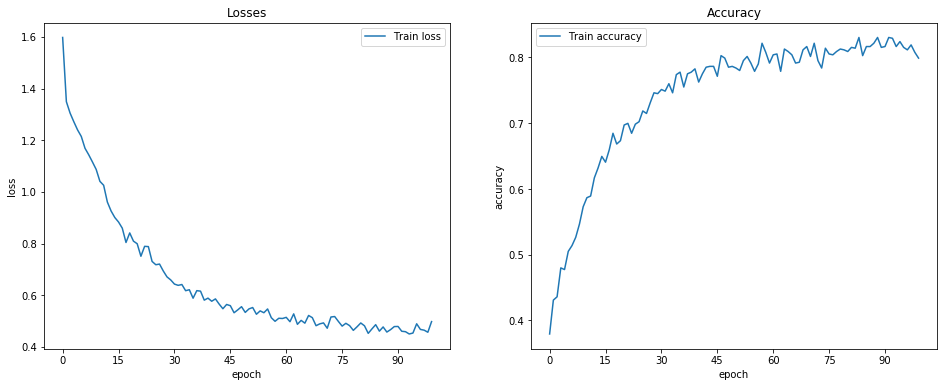

In [95]:
epochs = 100
history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=epochs, 
    verbose=0, 
    callbacks=[TrainProgressBar(max_value=epochs)], 
    # validation_split=0.2, 
    shuffle=True)
plot_history(history)

In [10]:
model.evaluate(X_test, y_test)

141/141 [==============================] - 0s 681us/step


[0.3451385633319828, 0.8794326249589312]

## Test on new images

In [12]:
test_path = './data/test/'
predictor_path = './dlib_landmarks_predictor/shape_predictor_68_face_landmarks.dat'

@interact(image = list(Path(test_path).glob('*.jpg')))
def predict(image):
    predictions = []
    img = imread(image.as_posix())
    _, landmarks = detect_faces(img, predictor_path, plot=True, plot_landmarks=False)
    for i, points in enumerate(landmarks):
        distances = points_to_distances(points, normalize=True)
        model_output = model.predict(distances[np.newaxis]).squeeze()
        label = np.argmax(model_output)
        class_name = classes_categorical[label]
        print('[{}] {} ({})'.format(i, class_name, model_output))

interactive(children=(Dropdown(description='image', options=(PosixPath('data/test/1290921548_1.jpg'), PosixPat…

## Save the trained model

In [92]:
# model.save('./models/ff_1000_700_500_500.h5')
# model.save_weights('./models/ff_1000_700_500_500_weigths.h5')
# tf.keras.utils.plot_model(model, to_file='./models/ff_1000_700_500_500.png', show_shapes=True, show_layer_names=True)